In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.graphics.gofplots as sm
from scipy import stats
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
from scipy.stats import permutation_test
from statsmodels.stats.power import TTestIndPower
from pathlib import Path
%matplotlib inline

In [2]:
def read_store_csvs(path: Path):
    file_paths = [f for f in path.glob('store*.csv')]
    files = [pd.read_csv(f, low_memory=False) for f in file_paths]
    return file_paths, files

csvs_dir = Path("data")
file_paths, files = read_store_csvs(csvs_dir)
for file in files:
    file.set_index('Store', inplace=True)
stores_df = pd.concat(files[1:], axis=1)
store_data = files[0]
state_names = pd.read_csv(csvs_dir / 'state_names.csv')


In [3]:
def map_string_column(df: pd.DataFrame, column_name: str):
    unique_label_list = df[column_name].unique()
    label_dict = { unique_label_list[i]: i for i in range(len(unique_label_list)) }
    df[column_name] = df[column_name].map(label_dict)
    return df, label_dict

In [4]:
store_data, holidays_dict = map_string_column(store_data, 'StateHoliday')
store_data.Date = pd.to_datetime(store_data.Date)
store_data

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
1,5,2015-07-31,5263,555,1,1,0,1
2,5,2015-07-31,6064,625,1,1,0,1
3,5,2015-07-31,8314,821,1,1,0,1
4,5,2015-07-31,13995,1498,1,1,0,1
5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...
1111,2,2013-01-01,0,0,0,0,1,1
1112,2,2013-01-01,0,0,0,0,1,1
1113,2,2013-01-01,0,0,0,0,1,1


In [5]:
stores_df['Assortment'] = pd.Series(stores_df['Assortment'], dtype='string')
stores_df['StoreType'] = pd.Series(stores_df['StoreType'], dtype='string')
stores_df.reset_index(inplace=True)
stores_df, states_dict = map_string_column(stores_df, 'State')
stores_df

,Store,State,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,2,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,3,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,4,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1110,1111,2,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1111,1112,2,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,5,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,11,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [6]:
states_dict

{'HE': 0,
 'TH': 1,
 'NW': 2,
 'BE': 3,
 'SN': 4,
 'SH': 5,
 'HB,NI': 6,
 'BY': 7,
 'BW': 8,
 'RP': 9,
 'ST': 10,
 'HH': 11}

In [7]:
state_names = pd.read_csv(csvs_dir / 'state_names.csv')
state_names['Numeric'] = state_names['State'].map(states_dict)
state_names.sort_values(by='Numeric', ascending=True, inplace=True)
state_names['Numeric'] = pd.Series(state_names['Numeric'], dtype='int')
state_names.dropna(inplace=True)
state_names

,StateName,State,Numeric
6,Hessen,HE,0.0
15,Thueringen,TH,1.0
9,NordrheinWestfalen,NW,2.0
2,Berlin,BE,3.0
12,Sachsen,SN,4.0
14,SchleswigHolstein,SH,5.0
8,Niedersachsen,"HB,NI",6.0
1,Bayern,BY,7.0
0,BadenWuerttemberg,BW,8.0
10,RheinlandPfalz,RP,9.0


In [8]:
weather = pd.read_csv(csvs_dir / 'weather.csv')
weather.Date = pd.to_datetime(weather.Date)
weather['State'] = pd.Series(weather['State'], dtype='string')
statename_to_state_id_dict = state_names[['StateName', 'Numeric']].set_index('StateName').to_dict()['Numeric']
weather['State'] = weather['State'].map(statename_to_state_id_dict)
weather.dropna(inplace=True)
weather['State'] = pd.Series(weather['State'], dtype='int')
weather

,State,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,2,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
24,2,2013-01-25,-2,-2,-3,-3,-4,-6,95,83,...,26.0,9.0,1.0,23,8,40.0,0.00,7.0,Fog-Rain-Snow,80
25,2,2013-01-26,0,-2,-4,-1,-4,-6,100,81,...,26.0,11.0,3.0,34,24,48.0,0.00,7.0,Rain-Snow,158
26,2,2013-01-27,4,2,-1,3,1,-2,95,86,...,26.0,12.0,5.0,35,21,53.0,3.05,7.0,Rain-Snow,174
28,2,2013-01-29,12,8,3,10,8,3,96,88,...,31.0,12.0,6.0,45,31,61.0,6.10,7.0,Rain,216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14833,1,2015-09-01,27,21,14,17,13,11,88,64,...,31.0,14.0,10.0,43,13,52.0,0.00,6.0,Rain,266
14838,1,2015-09-06,15,11,7,9,7,6,88,75,...,31.0,11.0,10.0,42,27,60.0,0.00,4.0,Rain,269
14842,1,2015-09-10,16,12,8,9,8,6,94,81,...,31.0,13.0,6.0,26,8,45.0,2.03,6.0,Rain-Thunderstorm,36
14846,1,2015-09-14,19,16,12,15,12,10,98,78,...,26.0,11.0,5.0,42,13,61.0,8.89,6.0,Rain-Thunderstorm,202


# Analiza pod kątem zamknięcia sklepu

In [9]:
closed_count = store_data[store_data['Open'] == 0].count()[0]
print('Ilość zamkniętych sklepów (łącznie): ', closed_count)
national_holiday = store_data[store_data['StateHoliday'] == holidays_dict['a']].count()[0]
print('Ilość zamkniętych w święta państwowe i procentowy udział (łącznie): ', national_holiday, " | ", national_holiday/float(closed_count))
easter_holiday = store_data[store_data['StateHoliday'] == holidays_dict['b']].count()[0]
print('Ilość zamkniętych w święta wielkanocne i procentowy udział (łącznie): ', easter_holiday, " | ", easter_holiday/float(closed_count))
xmas_holiday = store_data[store_data['StateHoliday'] == holidays_dict['c']].count()[0]
print('Ilość zamkniętych w święta bożego narodzenia i procentowy udział (łącznie): ', xmas_holiday, " | ", xmas_holiday/float(closed_count))

Ilość zamkniętych sklepów (łącznie):  172817
Ilość zamkniętych w święta państwowe i procentowy udział (łącznie):  20260  |  0.11723383694891128
Ilość zamkniętych w święta wielkanocne i procentowy udział (łącznie):  6690  |  0.038711469357759945
Ilość zamkniętych w święta bożego narodzenia i procentowy udział (łącznie):  4100  |  0.02372451784257336


Na potrzeby późniejszej analizy powyższe dni nie zostaną uznane w danych ponieważ nie mają one wpływu na sprzedawalność, natomiast w chwili gdy jeden z wielu regionów ma święto kiedy reszta ich nie ma spowoduje to wysokie rozbieżności danych, które chciałbym wyeliminować.


In [10]:
store_data = pd.DataFrame(store_data[store_data['Open'] == 1])

In [11]:
store_data.sort_values('Date', ascending=True)
no_sales_stores = store_data[store_data['Sales'] == 0]
store_data = store_data[store_data['Sales'] > 0]
no_sales_stores

,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Store,,,,,,,,
971,5,2015-05-15,0,0,1,0,0,1
674,4,2015-03-26,0,0,1,0,0,0
699,4,2015-02-05,0,0,1,1,0,0
708,3,2014-10-01,0,0,1,1,0,0
357,1,2014-09-22,0,0,1,0,0,0
227,4,2014-09-11,0,0,1,0,0,0
835,4,2014-09-11,0,0,1,0,0,0
835,3,2014-09-10,0,0,1,0,0,0
548,5,2014-09-05,0,0,1,1,0,1


W danych braku sprzedaży nie występują przypadki w których dane wyglądają niepokojąco. Wiele sklepów nie występuje wiele razy w różnych okresach czasu co może sugerować przykładowo, remonty techniczne, wymiany kas itp. w związku z tym dane zostaną odrzucone żeby nie sugerować się przypadkowymi awariami i innymi czynnikami zewnętrznymi źle wpływającymi na funkcjonowanie samego sklepu tak samo jak możliwe outliery spowodowane potencjalnym brakiem danych.

<AxesSubplot:>

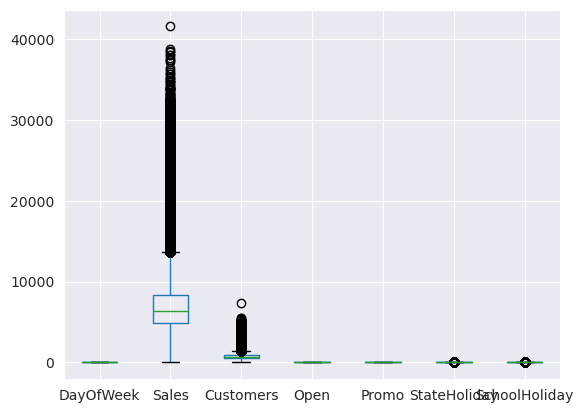

In [12]:
store_data.boxplot()

<AxesSubplot:>

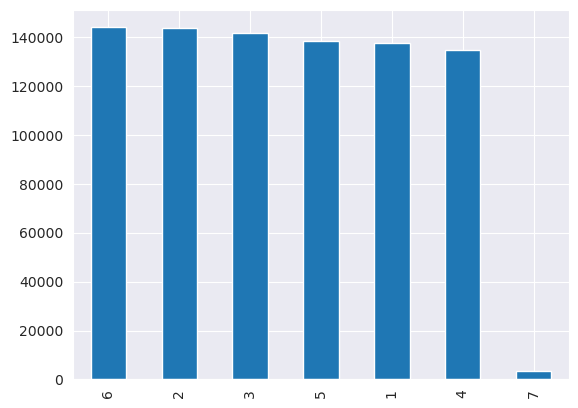

In [13]:
store_data['DayOfWeek'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

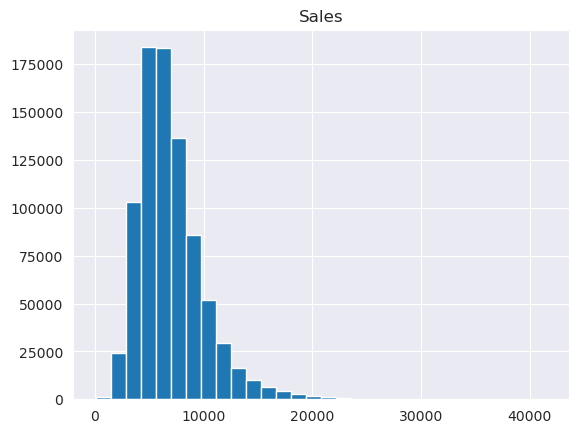

In [16]:
store_data.hist('Sales', bins=30)

array([[<AxesSubplot:title={'center':'Sales'}>]], dtype=object)

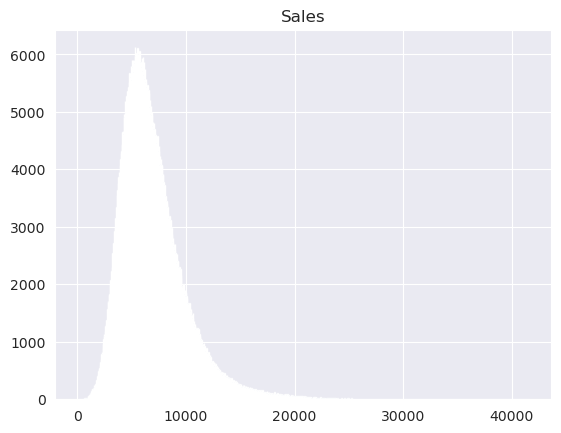

In [15]:
store_data.hist('Sales', bins=1000)

Na podstawie histogramów (pierwszy z małą ilością binów i drugi z dużą żeby zobaczyć dokładną dystrybucje danych) można stwierdzić że rozkład sprzedaży jest prawostronnie skośny oznacza to że wiele danych które mogą zostać potraktowane jako outliery (dane znajdujące się dalej prawej strony rozkładu, sugerując się medianą), mimo tego że nie oznacza to że dane te w istocie są outlierami na co trzeba uważać w kolejnych krokach